In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import make_classification
#import pandas as pd
#import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from collections import defaultdict

import sklearn.datasets

torch.manual_seed(1)
np.random.seed(7)
#sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.7.1


In [2]:
import time
from torchvision import datasets, transforms


# Dataset and Model Definition

In [373]:
BATCH_SIZE=1024

In [374]:
transform=transforms.Compose([
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: torch.flatten(x)),
    #transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=BATCH_SIZE)
n_features = 784
n_classes = 10

In [376]:
class Classifier(nn.Module):
    def __init__(self, n_features):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            torch.nn.Conv2d(1, 16, 8, 2, padding=3, bias=False),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 1), 
            torch.nn.Conv2d(16, 32, 4, 2, bias=False), 
            torch.nn.ReLU(), 
            torch.nn.MaxPool2d(2, 1), 
            torch.nn.Flatten(), 
            torch.nn.Linear(32 * 4 * 4, 32, bias=False), 
            torch.nn.ReLU(), 
            torch.nn.Linear(32, 10, bias=False),
            nn.LogSoftmax()
    )
        
    def forward(self, x):
        return self.network(x)

In [378]:
def accuracy(model, X, y):
    Xt = torch.from_numpy(X).float()
    yt = torch.from_numpy(y).long()
    outputs = model(Xt)
    y_hat = [1 if o>.5 else 0 for o in outputs]
    accuracy = np.sum(y_hat == y) / len(y)
    return accuracy

# Training

In [379]:
def make_plot(info, key, title):
    plt.plot(info[key]);
    plt.title(title)
    plt.show()

In [380]:
UPSTREAM_GRAD_BOUND = 0.0001
INPUT_BOUND = 1

In [381]:
def l2_clip(t, C):
    dims = tuple(range(1, len(t.shape)))
    norm = t.norm(dim=dims, keepdim=True, p=2).expand(t.shape)
    clipped = torch.where(norm > C, C*(t/norm), t)
    #t[norm > C] = (C*(t/norm)).flatten()
    #new_norms = clipped.norm(dim=dims, p=2)

    return clipped

In [382]:
def clamp_grad(self, grad_input, grad_output):
    if isinstance(self, nn.Linear):
        upstream_g, g_weights = grad_input
        if upstream_g == None:
            return grad_input
        else:
            self.grad_maxes.append(upstream_g.abs().max().item())

            return (l2_clip(upstream_g, UPSTREAM_GRAD_BOUND), g_weights)
    elif isinstance(self, nn.ReLU):
        self.grad_maxes.append(grad_input[0].abs().max().item())

        return (l2_clip(grad_input[0], UPSTREAM_GRAD_BOUND),)
    else:
        return None

In [383]:
def clamp_grad(self, grad_input, grad_output):
    # we assume there is always a ReLU or LogSoftMax layer right before something with weights
    if isinstance(self, (nn.ReLU, nn.LogSoftmax)):
        g = grad_input[0]
        self.grad_maxes.append(g.abs().max().item())
        return (l2_clip(g, UPSTREAM_GRAD_BOUND),)

In [384]:
input_maxes = []
def clamp_input(self, input):
    self.input_maxes.append(input[0].abs().max().item())
    return tuple([l2_clip(x, INPUT_BOUND) for x in input])

In [385]:
def zcdp_eps(rho, delta):
    return rho + 2*np.sqrt(rho*np.log(1/delta))

In [406]:
def run_experiment(epsilon, epochs, add_noise=False):
    model = Classifier(n_features=n_features)
    model.to('cuda')
    model.network.to('cuda')
    model_criterion = nn.NLLLoss() 
    model_optimizer = optim.Adam(model.parameters(), lr=0.01)#, weight_decay=0.0001)
    rho_i = 0.0000001
    total_rho = 0
    
    for x in model.network:
        x.input_maxes = []
        x.grad_maxes = []
        x.register_backward_hook(clamp_grad)
        x.register_forward_pre_hook(clamp_input)
    
    sensitivities = []
    norms = []
    decays = []
    losses = []
    
    model.train()
    # sensitivity for everything with weights is just:
    sensitivity = INPUT_BOUND * UPSTREAM_GRAD_BOUND / BATCH_SIZE
    sigma = np.sqrt(sensitivity**2 / (2*rho_i))
    print('sensitivity:', sensitivity)
    
    for epoch in range(epochs):
        for x_batch_train, y_batch_train in train_loader:
            xb = x_batch_train.to('cuda')
            yb = y_batch_train.to('cuda')
            model_optimizer.zero_grad()
            outputs = model.forward(xb)
            loss = model_criterion(outputs, yb)
            losses.append(loss)
            loss.backward()
            
            for p in model.parameters():
                with torch.no_grad():
                    p.grad += sigma * torch.randn(p.shape).to('cuda')
                    total_rho += rho_i

            norms.append(next(model.parameters()).data.norm())

            model_optimizer.step()
            

    total_weights = 0
    for p in model.parameters():
        total_weights += p.flatten().shape[0]
    print('total weights:', total_weights)

    info = {'sens': sensitivities,
            'norms': norms,
            'decays': decays,
            'losses': losses,}
    print('total rho:', total_rho)
    print('total epsilon:', zcdp_eps(total_rho, 1e-5))
    return model, info

In [407]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cuda'), target.to('cuda')
            output = model(data)
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

sensitivity: 9.765625e-08
total weights: 25920
total rho: 0.0002360000000000049
total epsilon: 0.1044866673308719


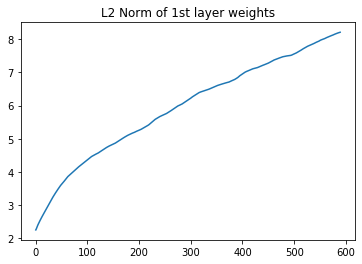

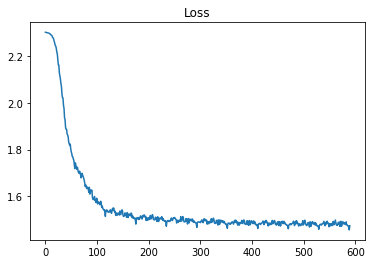

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Test set: Average loss: 1.4772, Accuracy: 9620/10000 (96.20%)

CPU times: user 59.9 s, sys: 23.8 ms, total: 60 s
Wall time: 59.9 s


In [411]:
%%time

model, info = run_experiment(.001, 10, False)

for key, title in [#('sens', 'Sensitivity'), 
                   ('norms', 'L2 Norm of 1st layer weights'),
                   #('decays', 'Weight Decay Value'),
                   ('losses', 'Loss')
                ]:
    make_plot(info, key, title)

test(model, test_loader)

Layer: 1 ReLU mean gradient max: nan
Layer: 4 ReLU mean gradient max: nan
Layer: 8 ReLU mean gradient max: nan
Layer: 10 LogSoftmax mean gradient max: nan


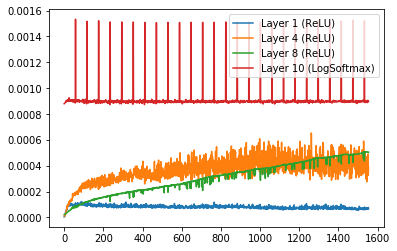

In [399]:
for i, layer in enumerate(model.network):
    if isinstance(layer, (nn.ReLU, nn.LogSoftmax)):
        plt.plot(layer.grad_maxes, label=f'Layer {i} ({type(layer).__name__})')
        print('Layer:', i, type(layer).__name__, 'mean gradient max:', torch.tensor(layer.grad_maxes).mean().item())
plt.legend();

Layer: 0 Conv2d mean input max: 1.0
Layer: 3 Conv2d mean input max: nan
Layer: 7 Linear mean input max: nan
Layer: 9 Linear mean input max: nan


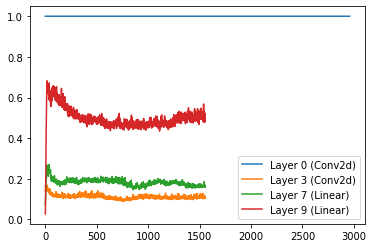

In [400]:
for i, layer in enumerate(model.network):
    if isinstance(layer, (nn.Linear, nn.Conv2d)):
        plt.plot(layer.input_maxes, label=f'Layer {i} ({type(layer).__name__})')
        #print(layer.input_maxes[0])
        print('Layer:', i, type(layer).__name__, 'mean input max:', torch.tensor(layer.input_maxes).mean().item())

plt.legend();

In [106]:
import gc

gc.collect()

torch.cuda.empty_cache()